# Title

## Setup

[ランタイム] → [ランタイムのタイプを変更] → [ハードウェアアクセラレータ] を `GPU` にする。


## 環境確認

In [0]:
!python --version
!pip --version
!pip list

# tesorflow 2.0 には、 keras >= 2.3.0 が必要
!pip install -U keras

Python 3.6.9
pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.0.1          
asgiref                  3.2.7          
astor                    0.8.1          
astropy                  4.0.1          
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.3.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
beautifulsoup4           4.6.3          
bleach                   3.1.4          
blis                     0.4.1          
bokeh                    1.4.0          
boto3                    1.12.31        
botocore     

## 共通ライブラリインポート



In [0]:
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.pooling import MaxPool2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import plot_model, np_utils

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


## 学習済みモデルインポート


In [0]:
# from keras.applications import VGG16

## 処理固有ライブラリインポート

60000枚の サイズ 32x32 のカラー(RGB: 3チャンネル) の画像データを使用する。
画像は 50000枚の学習データと 10000枚のテストデータに分けられる。

画像は10種類の分類分けがされている。

- 0:飛行機
- 1:自動車
- 2:鳥
- 3:猫
- 4:鹿
- 5:犬
- 6:蛙
- 7:馬
- 8:船
- 9:トラック

各画像がどの分類化を推測するのがゴールである。


(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


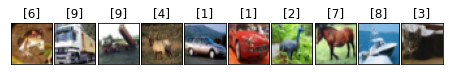

In [0]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

fig = plt.figure()
fig.subplots_adjust(
    left=0, right=1, bottom=0,
    top=0.5, hspace=0.05, wspace=0.05
    )

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train[i]))
    ax.imshow(x_train[i])


## 共通変数定義

In [0]:
nb_epochs = 20
batch_size = 32

## 処理固有変数定義

In [0]:
img_rows, img_cols = 32, 32
img_channels = 3

nb_classes = 10

## 正規化 (Normalization)

特徴量の値の範囲を一定の範囲におさめる変換。以下は `[0, 1]` におさめる変換。

正規化を使用するのは、

- 画像処理におけるRGBの強さ[0,255]
- sigmoid, tanhなどの活性化関数を用いる、NNのいくつかのモデル


In [0]:
def normalize(x):
    max_x = np.max(x, axis=(0, 1), keepdims=True)
    min_x = np.min(x, axis=(0, 1), keepdims=True)
    return (x - min_x) / (max_x - min_x)

x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)

print(x_train.shape, x_train[0][0][0])
print(x_train_norm.shape, x_train_norm[0][0][0])

# 画像の場合、値は 0 - 255 なことが多いので、上の式で、 min_x = 0 と同じ。
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0


(50000, 32, 32, 3) [59 62 63]
(50000, 32, 32, 3) [0.23137255 0.24313725 0.24705882]


1層目は、上記により正規化されるが、2層目以降も正規化をしたい。
それが Batch Normalization。
2層目以降の偏った状態のことを共変量シフトがあるという。


## 標準化 (Standardization)

特徴量の平均を0、分散を1にする変換。値から平均を引いて、標準偏差で割る。

標準化を使うのは、

- ロジスティック回帰、SVM、NNなど勾配法を用いたモデル
- kNN, k-meansなどの距離を用いるモデル
- PCA, LDA(潜在的ディリクレ配分法), kernel PCA などのfeature extractionの手法


In [0]:
def standardize(x):
    mean_x = np.mean(x, axis=(0, 1), keepdims=True)
    std_x = np.std(x, axis=(0, 1), keepdims=True)
    return (x - mean_x) / std_x

x_train_std = standardize(x_train)
x_test_std = standardize(x_test)

print(x_train.shape, x_train[0][0][0])
print(x_train_std.shape, x_train_std[0][0][0])

(50000, 32, 32, 3) [59 62 63]
(50000, 32, 32, 3) [-1.02513517 -1.01730447 -0.79326181]


以下のモデルでは、正規化も標準化も使わない。

- 決定木、ランダムフォレスト

## One-Hot 表現

名義尺度の値を One-Hot 表現に変換する。

In [0]:
y_train_oh = np_utils.to_categorical(y_train, nb_classes)
y_test_oh = np_utils.to_categorical(y_test, nb_classes)

print(y_train.shape, y_train[0])
print(y_train_oh.shape, y_train_oh[0])


(50000, 1) [6]
(50000, 10) [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## 初期化

ReLUを使う場合は、Heを使う。 ReLU以外を使う場合は、Xavier初期化を使うと良い。

## 活性化関数

### 出力ユニット

#### 線形ユニット

出力の値が丸まってほしくない(0-1とかになってほしくない)(株価を予測する場合とか)に出力層に用いる。

#### シグモイドユニット

値が0-1に丸まるので、確率を求めたいときは非常に有効。

#### ソフトマックスユニット

シグモイドを拡張して、多変数に対応させた。
多変数の出力の値の合計が1になるようになっている(シグモイドだとこれができない)。

### 隠れ層

基本的に ReLU でよい

#### シグモイドユニット(sigmoid)・ハイパボリックタンジェント(tanh)

どちらも非線形性が弱い。(部分的に見るとほぼ線形、とも見える)(入力を曲げる力が弱い)

#### 正規化線形関数(ReLU, Rectified Linear Unit)

原点で微分できないが、劣微分を考えればよい。傾きが0の部分がある。Dead Neuronが出る。
